# Input uncertainty

*Written by Félix Pollet (ISAE-SUPAERO), Marc Budinger (INSA Toulouse), Scott Delbecq (ISAE-SUPAERO), Jean-Marc Moschetta (ISAE-SUPAERO), and Jonathan Liscouët (Concordia University).*

In this notebook, uncertainty arising from unknown component's availability on the market at early stages of the design process is evaluated.

To assist in the process, existing databases of components are analysed:

1. The [APC propellers](https://www.apcprop.com/) database, for which the diameters distribution is analyzed.
2. The [ABB motors](https://new.abb.com/motors-generators) database, for which the nominal torque distribution is analyzed.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as ticker
from scipy.stats import uniform, iqr

## 1. APC Propellers

The propellers database provided by APC contains about 700 propellers in the range [4.1 - 28] inches ([0.104 - 0.711] meters). In this study, focus is made on propellers whose diameters lie between 6 inches and 16 inches and tailored for multi-rotor drones.

First, we import the database stored in a .csv file:

In [2]:
# Librairies path
path='./Data/'

# Import database
df = pd.read_csv(path+'Propellers_APC.csv', sep=';')

# Filter range of diameters
df = df[df['Diameter (INCHES)'] <= 16]
df = df[df['Diameter (INCHES)'] >= 6]
df = df[df['Categories'].str.contains('Multi Rotor')]

# Parameter of interest
x_name = 'Diameter (METERS)'

# Display first lines of database
df.describe()

,Price ($),Diameter (INCHES),Diameter (METERS),Pitch (INCHES),Pitch-to-diameter ratio (-),UPC Code,Product Weight (NOT for Shipping Calculations) (LBS),Product Weight (NOT for Shipping Calculations) (grams)
count,82.000000,82.000000,82.000000,82.000000,82.000000,8.200000e+01,82.000000,82.000000
mean,5.709024,10.487805,0.266390,4.760976,0.479671,6.870000e+11,0.038766,17.582927
std,10.576449,2.758797,0.070073,0.841480,0.140101,0.000000e+00,0.028767,13.049817
min,2.470000,6.000000,0.152400,3.000000,0.316700,6.870000e+11,0.011300,5.100000
25%,2.930000,9.000000,0.228600,4.500000,0.380000,6.870000e+11,0.020000,9.100000
50%,3.800000,10.000000,0.254000,4.500000,0.450000,6.870000e+11,0.033100,15.000000
75%,4.590000,12.000000,0.304800,5.500000,0.522200,6.870000e+11,0.048800,22.100000
max,71.500000,16.000000,0.406400,7.000000,1.000000,6.870000e+11,0.163100,74.000000


A mapping error function is defined to compute the error between a continuous value and the closest value in the database:

In [3]:
def mapping_error(df: pd.DataFrame, colname, x) -> float:
    """
    Computes the error between a continuous value and the closest value in a database.
    """
    df_sort = df.iloc[(df[colname]-x).abs().argsort()[:1]]  # get row corresponding to closest discrete value
    closest_value = df_sort[colname].unique()[0]  # get discrete value
    error = closest_value - x  # error between discrete value and continuous value
    return error

The mapping error is then calculated in the range of the diameters:

In [4]:
# Compute errors
step_size = 1e-5  # modify this step size according to your problem. Smaller is better.
x_array = np.arange(df[x_name].min(),df[x_name].max(),step_size)  # range and steps for errors calculation
error_array = []
for x in x_array:
    error_array.append(mapping_error(df, x_name, x))
error_array = np.asarray(error_array)

C:\Users\f.pollet.ISAE-SUPAERO\AppData\Local\Temp\ipykernel_6948\557753827.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_sort = df.iloc[(df[colname]-x).abs().argsort()[:1]]  # get row corresponding to closest discrete value


Now, let's plot the errors' distribution and the fitted uniform distribution:

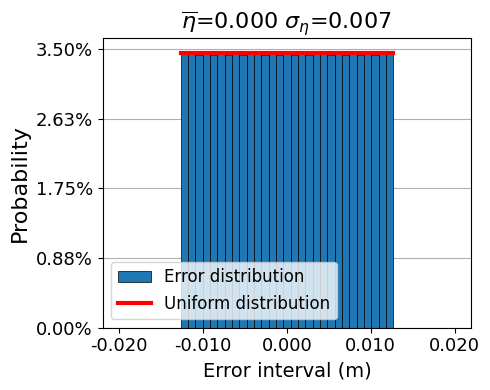

In [5]:
# 1) Plot of the probability density function

# Create figure
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(5,4))

# Set number of bins for histogram
bin_width = 2 * iqr(error_array) / error_array.size**(1/3)
n_bins = int((np.amax(error_array) - np.amin(error_array)) / bin_width)

# Set x axis
x = np.linspace(np.amin(error_array), np.amax(error_array), 1000)

# Probability density function
N, bins, patches = ax.hist(error_array, bins=n_bins, density=True, edgecolor='black', linewidth=0.5, label="Error distribution")
    
# Fitted uniform distribution
# left, W = uniform.fit(error_array)  # with scipy.stats
W = 2 * np.std(error_array) * np.sqrt(3)  # with uniform distribution properties
left = np.mean(error_array) - 0.5 * W 
dist = uniform(left, W)
ax.plot(x, dist.pdf(x), c='r', lw=3, label="Uniform distribution")
    
# Customize axes, title and display
title = ("$\overline{\eta}$="
              + "{:.3f} ".format(np.mean(error_array))
              + "$\sigma_{\eta}$="
              + "{:.3f} ".format(np.std(error_array)))
ax.set_title(title, fontsize=16)
ax.set_xlabel("Error interval (m)", fontsize=14)
ax.set_ylabel(r"Probability", fontsize=16)
ax.legend(fontsize=12)
ax.set_xlim([-3 * np.std(error_array) + np.mean(error_array), 3 * np.std(error_array) + np.mean(error_array)])
ax.xaxis.set_major_formatter('{x:1.3f}')
ax.yaxis.set_major_formatter(PercentFormatter(xmax=np.amax(dist.pdf(x))*n_bins))
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid(axis='y')
ax.set_axisbelow(True);

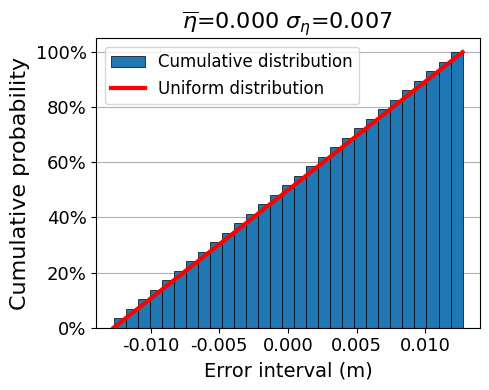

In [6]:
# 2) Plot of the cumulative density function

# Create figure
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(5,4))

# Set x axis
x = np.linspace(np.amin(error_array), np.amax(error_array), 1000)

# Cumulative density function
N, bins, patches = ax.hist(error_array, bins=n_bins, density=True, cumulative=True, edgecolor='black', linewidth=0.5, label="Cumulative distribution")
    
# Fitted uniform distribution
ax.plot(x, dist.cdf(x), c='r', lw=3, label="Uniform distribution")

# Customize axes, title and display
title = ("$\overline{\eta}$="
              + "{:.3f} ".format(np.mean(error_array))
              + "$\sigma_{\eta}$="
              + "{:.3f} ".format(np.std(error_array)))
ax.set_title(title, fontsize=16)
ax.set_xlabel("Error interval (m)", fontsize=14)
ax.set_ylabel(r"Cumulative probability", fontsize=16)
ax.legend(fontsize=12)
ax.xaxis.set_major_formatter('{x:1.3f}')
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid(axis='y')
ax.set_axisbelow(True);

The constant step $d$ of the design variable $x$ is obtained directly from the uniform distribution. It can also be calculated from the parameter range $[x_{max}, x_{min}]$ in the database and the number of distinct values $n$ in the database for parameter $x$:

In [7]:
# number of distinct values in the database for parameter x
n = df.drop_duplicates(subset = [x_name])[x_name].count()

# average difference between two consecutive terms
d = (df[x_name].max() - df[x_name].min()) / (n - 1) 

print(r"Constant step d = " + str(d))

Constant step d = 0.0254


## 2. ABB motors

The database provided by ABB contains electric motors whose nominal torque lie in the range [1.7 - 8075] N.m. In this study, focus is made on the [1.7 - 200] N.m range, with 15 products.

In [8]:
# Librairies path
path='./Data/'

# Import database
df = pd.read_csv(path+'Motors_ABB_IE3_cast_iron_750rpm_400V_50Hz.csv', sep=';')

# Filter range of nominal torques
df = df[df['Tnom_Nm']<=200]

# Parameter of interest
x_name = 'Tnom_Nm'

# Display first lines of database
df.describe()

,output_kW,speed_r_min,eff_full_load,eff_half_load,power_factor,current_A,Tnom_Nm,Inertia,weight_kg,sound_dB
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,3.534667,711.800000,76.680000,73.786667,0.638000,8.460667,46.210667,0.072075,88.333333,54.133333
std,4.468167,23.994642,11.606722,14.315719,0.062701,9.768528,57.914947,0.119081,82.920501,5.289702
min,0.120000,659.000000,50.700000,41.900000,0.530000,0.490000,1.700000,0.001070,11.000000,43.000000
25%,0.460000,706.500000,71.150000,64.350000,0.600000,1.685000,6.330000,0.006400,30.000000,51.500000
50%,1.500000,717.000000,79.700000,78.800000,0.650000,4.120000,19.900000,0.019400,53.000000,55.000000
75%,4.750000,731.500000,85.500000,84.650000,0.685000,11.650000,61.850000,0.091000,131.000000,59.000000
max,15.000000,737.000000,89.600000,90.100000,0.740000,32.500000,194.000000,0.450000,290.000000,60.000000


Similarly to the previous study case, a mapping error function is defined to compute the error between a continuous value and the closest value in the database. Here, the relative error is calculated (instead of the absolute error).

In [9]:
def mapping_error_relative(df: pd.DataFrame, colname, x) -> float:
    """
    Computes the relative error between a continuous value and the closest value in a database.
    """
    df_sort = df.iloc[(df[colname]-x).abs().argsort()[:1]]  # get row corresponding to closest discrete value
    closest_value = df_sort[colname].unique()[0]  # get discrete value
    error = 100 * (closest_value - x) / x  # relative error (in percent) between discrete value and continuous value
    return error

The relative error due to the discretization process is calculated for all torques in the range:

In [10]:
# Compute errors
step_size = 1e-2  # modify this step size according to your problem. Smaller is better.
x_array = np.arange(df[x_name].min(),df[x_name].max(),step_size)  # range and steps for errors calculation
error_array = []
for x in x_array:
    error_array.append(mapping_error_relative(df, x_name, x))
error_array = np.asarray(error_array)

The probability density function and the cumulative density function of the relative errors are now plotted and compared to a uniform distribution:

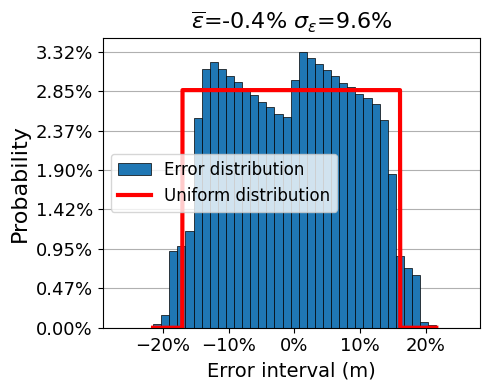

In [11]:
# 1) Plot of the probability density function

# Create figure
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(5,4))

# Set number of bins for histogram
bin_width = 2 * iqr(error_array) / error_array.size**(1/3)
n_bins = int((np.amax(error_array) - np.amin(error_array)) / bin_width)

# Set x axis
x = np.linspace(np.amin(error_array), np.amax(error_array), 1000)

# Probability density function
N, bins, patches = ax.hist(error_array, bins=n_bins, density=True, edgecolor='black', linewidth=0.5, label="Error distribution")
    
# Fitted uniform distribution
# left, W = uniform.fit(error_array)  # with scipy.stats
W = 2 * np.std(error_array) * np.sqrt(3)  # with uniform distribution properties
left = np.mean(error_array) - 0.5 * W 
dist = uniform(left, W)
ax.plot(x, dist.pdf(x), c='r', lw=3, label="Uniform distribution")
    
# Customize axes, title and display
title = ("$\overline{\epsilon}$="
              + "{:.1f}% ".format(np.mean(error_array))
              + "$\sigma_{\epsilon}$="
              + "{:.1f}%".format(np.std(error_array)))
ax.set_title(title, fontsize=16)
ax.set_xlabel("Error interval (m)", fontsize=14)
ax.set_ylabel(r"Probability", fontsize=16)
ax.legend(fontsize=12)
ax.set_xlim([-3 * np.std(error_array) + np.mean(error_array), 3 * np.std(error_array) + np.mean(error_array)])
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))
ax.yaxis.set_major_formatter(PercentFormatter(xmax=np.amax(dist.pdf(x))*n_bins))
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid(axis='y')
ax.set_axisbelow(True);

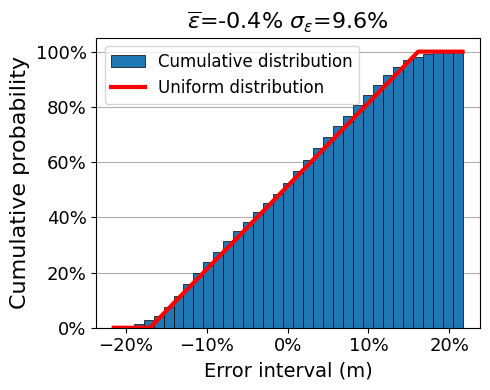

In [12]:
# 2) Plot of the cumulative density function

# Create figure
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(5,4))

# Set x axis
x = np.linspace(np.amin(error_array), np.amax(error_array), 1000)

# Cumulative density function
N, bins, patches = ax.hist(error_array, bins=n_bins, density=True, cumulative=True, edgecolor='black', linewidth=0.5, label="Cumulative distribution")
    
# Fitted uniform distribution
ax.plot(x, dist.cdf(x), c='r', lw=3, label="Uniform distribution")

# Customize axes, title and display
title = ("$\overline{\epsilon}$="
              + "{:.1f}% ".format(np.mean(error_array))
              + "$\sigma_{\epsilon}$="
              + "{:.1f}%".format(np.std(error_array)))
ax.set_title(title, fontsize=16)
ax.set_xlabel("Error interval (m)", fontsize=14)
ax.set_ylabel(r"Cumulative probability", fontsize=16)
ax.legend(fontsize=12)
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid(axis='y')
ax.set_axisbelow(True);

Finally, the common ratio $r$ is obtained from the fitted uniform distribution or with a few calculations on the database:

In [13]:
# number of distinct values in the database for parameter x
n = df.drop_duplicates(subset = [x_name])[x_name].count()

# average ratio between two consecutive terms
r = (df[x_name].max() / df[x_name].min()) ** (1 / (n - 1))

print(r"Common ratio r = " + str(r))

Common ratio r = 1.4026643916693151
